# Adaptative mesh deformation optimization

In [18]:
# !pip install ngsolve --upgrade
# !pip install webgui_jupyter_widgets --upgrade
# !pip install matplotlib --upgrade

from shapeOptInductor import create_plots, update_plots, rot
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt 


## 1 - Meshing of the inductor

In [19]:
from netgen.geom2d import SplineGeometry
from debug import *

def gen_mesh(air_gap=4.11e-3, maxh=1e-3, debug=False):
    """Gives a triangular mesh"""
    # Global domain
    r = 0.04

    # Geometry definition
    a = 1e-2
    h = 25e-3
    ba = 1e-2
    geo = SplineGeometry()
    pnts = [
        (0, 0),  # p0
        (a / 2, 0),  # p1
        (a / 2 + ba, 0),  # p2
        (r, 0),  # p3
        (r, r),  # p4
        (0, r),  # p5
        (0, h/2),  # p6
        (0, air_gap / 2),  # p7
        (a / 2, air_gap / 2),  # p8
        (a / 2, h / 2 - a / 2),  # p9
        (a / 2 + ba, h / 2 - a / 2),  # p10
        (a / 2 + ba, air_gap / 2),  # p11
        (a + ba, air_gap / 2),  # p12
        (a + ba, h / 2),  # p13
        ]
    
    maxhFine = maxh / 10
    maxhFine = maxh
    maxhMed = maxh / 5
    maxhMed = maxh 
    pointH = [
        maxh,  # p0
        maxh,  # p1
        maxh,  # p2
        maxh,  # p3
        maxh,  # p4
        maxh,  # p5
        maxh,  # p6
        maxhFine,  # p7
        maxhFine,  # p8
        maxh,  # p9
        maxh,  # p10
        maxhFine,  # p11
        maxhFine,  # p12
        maxh,  # p13
    ]

    (
        p0,
        p1,
        p2,
        p3,
        p4,
        p5,
        p6,
        p7,
        p8,
        p9,
        p10,
        p11,
        p12,
        p13,
    ) =  [
        geo.AppendPoint(*pnts[i], pointH[i]) for i in range(len(pnts))
    ]

    # List of lines with boundary conditions and domains
    lines = [
        [["line", p0, p1], {"bc": "a", "leftdomain": 3, "rightdomain": 0, "maxh": maxhMed}],
        [["line", p1, p2], {"bc": "b", "leftdomain": 2, "rightdomain": 0, "maxh": maxhMed}],
        [["line", p2, p3], {"bc": "c", "leftdomain": 4, "rightdomain": 0}],
        [["spline3", p3, p4, p5], {"bc": "d", "leftdomain": 4, "rightdomain": 0}],
        [["line", p5, p6], {"bc": "e", "leftdomain": 4, "rightdomain": 0}],
        [["line", p6, p7], {"bc": "f", "leftdomain": 1, "rightdomain": 0, "maxh": maxhMed}],
        [["line", p7, p0], {"bc": "g", "leftdomain": 3, "rightdomain": 0, "maxh": maxhMed}],
        [["line", p7, p8], {"bc": "h", "leftdomain": 1, "rightdomain":3, "maxh": maxhFine}],
        [["line", p8, p9], {"bc": "i", "leftdomain": 1, "rightdomain":2, "maxh": maxhMed }],
        [["line", p9, p10], {"bc": "j", "leftdomain": 1, "rightdomain":2, "maxh": maxhMed }],
        [["line", p10, p11], {"bc": "k", "leftdomain": 1, "rightdomain":2, "maxh": maxhMed }],
        [["line", p11, p12], {"bc": "l", "leftdomain": 1, "rightdomain": 4, "maxh": maxhFine}],
        [["line", p12, p13], {"bc": "m", "leftdomain": 1, "rightdomain": 4, "maxh": maxhMed}],
        [["line", p13, p6], {"bc": "n", "leftdomain": 1, "rightdomain": 4, "maxh": maxhMed}],
        [["line", p1, p8], {"bc": "o", "leftdomain": 3, "rightdomain": 2, "maxh": maxhMed}],
        [["line", p2, p11], {"bc": "p", "leftdomain": 2, "rightdomain": 4, "maxh": maxhMed}],
        
    ]

    # Append all lines to the geometry
    for line, props in lines:
        geo.Append(line, **props)

    # Optional matpotlib debug render
    if debug : 
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        debug_geo(geo, axes[0, 0])
        debug_points(geo, 
                     # point_names is optional
                     point_names="p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,p12,p13".split(","),
                     ax=axes[1, 0]
                     )
        debug_bc_names(geo, ax=axes[0, 1])
        debug_region_labels(geo, ax=axes[1, 1])
        plt.show()

    # Set materials and meshing parameters
    geo.SetMaterial(1, "core")
    geo.SetMaterial(2, "coil")
    geo.SetMaterial(3, "air")
    geo.SetMaterial(4, "air")
    ngmesh = geo.GenerateMesh(maxh=maxh)
    # return ngs.Mesh(ngmesh.Mirror((0, 0, 0), (-1, 0, 0)).Mirror((0, 0, 0), (0, -1, 0)))
    return ngs.Mesh(ngmesh)


mesh = gen_mesh(debug=False)
XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

Draw(mesh, radius=0.02)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - Computation of magnetic state and quantities of interest 

In [20]:
f = 5e4  # working frequency (Hz)
s = 4
lz = 1e-2

# Magnetic
mu0 = 4e-7 * np.pi
mur = 1000
mu_iron = mur * mu0
delta = 0.1
mu_coil = np.exp(-1j * delta) * mu0  #  AC losses in the copper from the imaginary part of the permeability
coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag

# Current
nb_turn = 200  # Number of turn in the coil
Is = 2  # Source current intensity
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # Source current density


def magWeakFormComplex(a, a_):
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")
    lf = a_ * js * ngs.dx("coil")
    return bf, lf


def solveStateComplex(fes):
    a, a_ = fes.TnT()
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f
    K.Assemble()
    F.Assemble()
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")  # Hermitian ?
    gf.vec.data = Kinv * F.vec
    return gf, Kinv

fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
state, Kinv = solveStateComplex(fes)
Draw(ngs.Norm(state), mesh, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [21]:
def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def Losses(a, mesh):
    return ngs.Integrate(coeff_losses * XiCoil * ngs.Norm(ngs.grad(a)) ** 2, mesh)


# For the augmented lagrangian
L_target = 1e-3


def Constraint(a, mesh):
    return Inductance(a, mesh) - L_target


In [22]:
fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
state, Kinv = solveStateComplex(fes)

print(f"The inductance is {1e3 * np.absolute(Inductance(state, mesh)):.3f} mH")
print(f"The losses amounts to {Losses(state, mesh):.3f} W")

The inductance is 0.982 mH
The losses amounts to 12.136 W


## 3 - Computation of adjoint states and shape derivatives

In [23]:
def solveAdjointLosses(a0, Kinv):
    """Solves the adjoint equation for the losses inside the coil"""
    fes = a0.space
    p, p_ = fes.TnT()
    F = ngs.LinearForm(fes)
    F += - 2 * coeff_losses * ngs.InnerProduct(ngs.grad(a0), ngs.grad(p_)) * ngs.dx("coil")
    F.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * F.vec
    return gf


def solveAdjointInductance(a0, Kinv):
    """Solves the adjoint equation for the inductance"""
    fes = a0.space
    p, p_ = fes.TnT()
    F = ngs.LinearForm(fes)
    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_induc =  s * lz / (Is**2) * rel
    F += -2 * coeff_induc * ngs.InnerProduct(ngs.grad(a0), ngs.grad(p_)).real * ngs.dx
    F.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data =  Kinv * F.vec
    return gf


def computeLossesShapeDerivative(mesh, VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the energy-based losses inside the coil"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_losses * XiCoil * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx("coil")
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx("coil|air|core")
    # dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx("air|core")

    dLOmega.Assemble()
    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def computeInductanceShapeDerivative(mesh, VEC_complex, VEC_real, a0, p0):
    """Shape derivative for the inductance"""
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ

In [24]:
maxh = 10e-4
mesh = gen_mesh(air_gap=4e-3, maxh=maxh)

fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True, dirichlet="d|e|f|g")
VEC_real = ngs.VectorH1(mesh)

state, Kinv = solveStateComplex(fes)
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)

dJOmega = computeInductanceShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_inductance)

Draw(adjoint_inductance, radius=0.02)
Draw(adjoint_losses.real, mesh, radius=0.02)  # Note that the imag part should be 0



WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 's…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 4 - Computation of descent direction (deformation field) with Hilbertian regularization-extension

In [25]:
def SolveDeformationEquation(mesh, fX):
    VEC = ngs.VectorH1(
        mesh,
        order=1,
        dirichlet="d",
        dirichletx="o|e|f|g|i|k|m|p",
        dirichlety="a|b|c|n|j",
    )
    PHI, X = VEC.TnT()

    # H1 dot product
    B = ngs.BilinearForm(VEC)
    B += ngs.InnerProduct(ngs.grad(X), ngs.grad(PHI)) * ngs.dx + ngs.InnerProduct(X, PHI) * ngs.dx
    B.Assemble()

    gfX = ngs.GridFunction(VEC)
    gfX.vec.data = -B.mat.Inverse(VEC.FreeDofs()) * fX.vec
    return gfX


# Without dirichlet conditions
dJ = ngs.GridFunction(VEC_real)
dJ.vec.FV().NumPy()[:] = dJOmega.vec.FV().NumPy()[:]
Draw(dJ, mesh, vectors={"grid_size": 40}, radius=0.02)

# With dirichlet conditions
descent_direction = SolveDeformationEquation(mesh, dJ)
Draw(descent_direction.real, mesh, vectors={"grid_size": 40}, radius=0.02)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 5 - Taylor tests

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

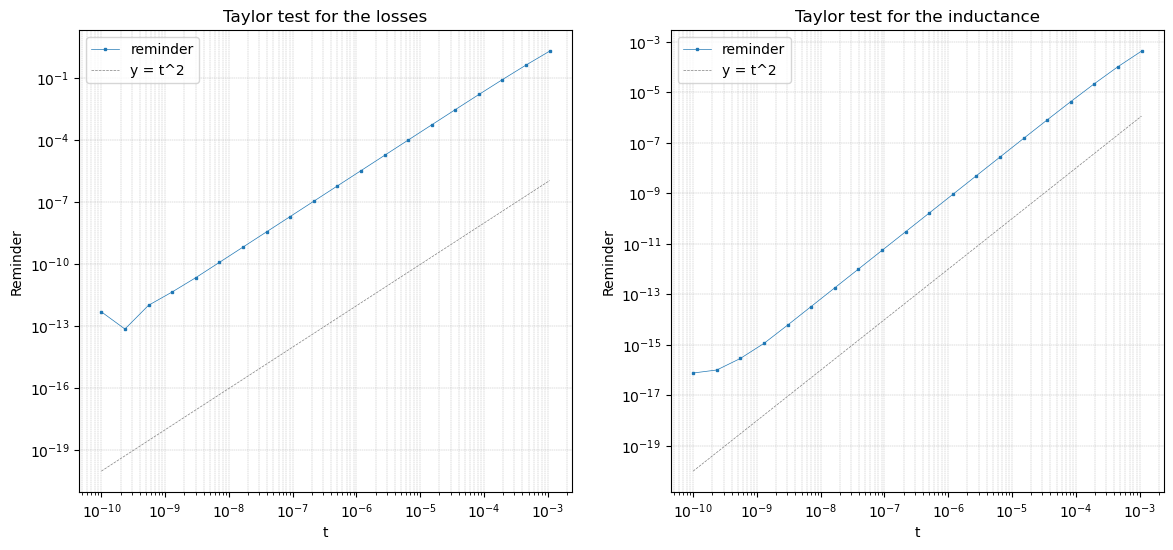

In [26]:
from mmglib import copy_ngmesh

def TaylorTest(cost, compute_adjoint, compute_shape_derivative, SolveDeformationEquation, title="Taylor test", maxh=1.5e-3, to_draw=False, ax=None):
    mesh = gen_mesh(air_gap=2e-3, maxh=maxh)
    fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
    VEC_complex = ngs.VectorH1(mesh, complex=True)
    VEC_real = ngs.VectorH1(mesh)
    a0, Kinv = solveStateComplex(fes)
    p0 = compute_adjoint(a0, Kinv)
    dJOmega = compute_shape_derivative(mesh, VEC_complex, VEC_real, a0, p0)

    nb_sample = 20
    exponent_min = 2.6
    exponent_max = 10
    reminders = []

    X = []

    # For transported mesh
    meshT = ngs.Mesh(copy_ngmesh(mesh.ngmesh))
    fesT = ngs.H1(meshT, order=1, dirichlet="d|e|f|g", complex=True)
    VEC_realT = ngs.VectorH1(meshT)

    direction = ngs.GridFunction(VEC_realT)
    direction = SolveDeformationEquation(meshT, dJOmega)
    direction.vec.FV().NumPy()[:] = direction.vec.FV().NumPy() / (1e-10 + np.max(np.abs(direction.vec.FV().NumPy())))

    if to_draw : scene = Draw(ngs.Norm(direction), meshT, radius=0.02)

    for i in range(nb_sample, 0, -1):
        # Abscissa axis in log scale
        t = 10 ** (-(i / nb_sample * (exponent_max - exponent_min) + exponent_min))
        X.append(t)

        # Finite difference
        displacement = ngs.GridFunction(VEC_realT)
        displacement.Set(t * direction)
        
        meshT.SetDeformation(displacement)
        aT, _ = solveStateComplex(fesT)
        difference = cost(aT, meshT) - cost(a0, mesh)
        if to_draw : scene.Redraw(ngs.Norm(direction), meshT, radius=0.02)

        # Reminder for analytic shape derivative
        reminder_value = np.abs(difference - ngs.InnerProduct(dJOmega.vec, t * direction.vec))
        reminders.append(reminder_value)

    Y = np.power(np.array(X), 2)
    # Create a new figure if no ax is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(X, reminders, label="reminder", marker="s")
    ax.plot(X, Y, label="y = t^2", linestyle="--", color="gray")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("t")
    ax.set_ylabel("Reminder")
    ax.set_title(title)
    ax.legend()
    ax.grid(True, which="both", ls="--")

    if ax is None:
        plt.tight_layout()
        plt.show()

maxh = 5e-3
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
TaylorTest(Losses, solveAdjointLosses, computeLossesShapeDerivative, SolveDeformationEquation, ax=axes[0], title="Taylor test for the losses", maxh=maxh, to_draw=True)
TaylorTest(Inductance, solveAdjointInductance, computeInductanceShapeDerivative, SolveDeformationEquation, ax=axes[1], title="Taylor test for the inductance", maxh=maxh, to_draw=False)
plt.show()

## 6 - Remeshing with mmg

In [27]:
# Initializations
mesh = gen_mesh(air_gap=4e-3, maxh=5e-3)
fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
VEC_complex = ngs.VectorH1(mesh, complex=True)
VEC_real = ngs.VectorH1(mesh)

l = 1e-2
b = 1e-1

# State and cost function
state, Kinv = solveStateComplex(fes)

# Adjoints, shape derivate then descent direction
adjoint_losses = solveAdjointLosses(state, Kinv)
adjoint_inductance = solveAdjointInductance(state, Kinv)
dJOmega = computeInductanceShapeDerivative(mesh, VEC_complex, VEC_real, state, adjoint_inductance)

descent_direction = SolveDeformationEquation(mesh, dJOmega)
currentNorm = ngs.Norm(descent_direction.vec)

def move_ngmesh_2D(displ, mesh):
    mat_displ = displ.vec.FV().NumPy()
    nb_points = len(mat_displ) // 2
    for i, point in enumerate(mesh.ngmesh.Points()):
        vx = mat_displ[i]
        vy = mat_displ[i + nb_points]
        point[0] += vx
        point[1] += vy
    mesh.ngmesh.Update()


from mmglib import run_adapt, copy_ngmesh

print("Moved mesh")
descent_direction.vec.data = 1e-6 * descent_direction.vec
move_ngmesh_2D(descent_direction, mesh)
# mesh.ngmesh.OptimizeMesh2d() # Does not work properly

# Test the descent of the cost
fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
state, Kinv = solveStateComplex(fes)

Draw(ngs.Norm(rot(state)), mesh, radius=0.02)

# print("copy of Initial mesh")
# Draw(ngs.Norm(rot(state)), copied_mesh, radius=0.02)

print("Optimized moved mesh")
new_ngmesh, return_code = run_adapt(mesh.ngmesh, hausd=1e-6, hmax=1e-3, hmin=1e-4)
new_mesh = ngs.Mesh(new_ngmesh)
fes = ngs.H1(new_mesh, order=1, dirichlet="d|e|f|g", complex=True)
state, Kinv = solveStateComplex(fes)
Draw(ngs.Norm(rot(state)), new_mesh, radius=0.02)

print(f"The inductance is {1e3 * np.absolute(Inductance(state, new_mesh)):.3f} mH")
print(f"The losses amounts to {Losses(state, new_mesh):.3f} W")

# print("Recover initial mesh")
# descent_direction.vec.data = -descent_direction.vec
# move_ngmesh_2D(descent_direction, mesh)
# fes = ngs.H1(mesh, order=1, dirichlet="d|e|f|g", complex=True)
# state, tangent_matrix = solveStateComplex(fes)
# Draw(ngs.Norm(rot(state)), mesh, radius=0.02)


Moved mesh


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Optimized moved mesh


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

The inductance is 1.006 mH
The losses amounts to 12.398 W


## 7 - Optimization


In [28]:
class DisplayListener:
    def __init__(self, mesh):
        self.fig, self.axes, self.hdisplay = create_plots(2)
        self.scene = Draw(1 * XiAir + 2 * XiCoil + 3 * XiCore, mesh, radius=0.02)
        self.export_count = 0

    def display(self, **args):
        data = [
                [args["losses_values"]],
                [args["inductance_values"]],
            ]
        curve_labels = [
            ["Conductor Losses (W)"],
            ["Inductance (mH)"],
        ]
        update_plots(self.fig, self.axes, self.hdisplay, data, curve_labels)

        self.scene.Redraw(1 * XiAir + 2 * XiCoil + 3 * XiCore, args["mesh"], radius=0.02)
        self.export_count += 1

In [29]:
from nullspace_optimizer import Optimizable
import scipy.sparse as sp

class ShapeOpt(Optimizable):
    def __init__(self, mesh, SolveDeformationEquation, use_mmg=False, mmg_hausd=1e-5, mmg_hmax=3e-3, mmg_hmin=5e-4, listener:DisplayListener=None):
        # Store initial parameters
        self.initial_mesh = mesh
        self.SolveDeformationEquation = SolveDeformationEquation
        self.use_mmg = use_mmg
        self.mmg_hausd = mmg_hausd
        self.mmg_hmax = mmg_hmax
        self.mmg_hmin = mmg_hmin
        self.listener = listener

        # Initialize state variables
        self.mesh = ngs.Mesh(copy_ngmesh(self.initial_mesh.ngmesh))
        self.fes = ngs.H1(self.mesh, order=1, dirichlet="d|e|f|g", complex=True)
        self.state, self.Kinv = solveStateComplex(self.fes)
        self.LossesInit = Losses(self.state, self.mesh)
        self.descent_direction = None

        # Data for monitoring
        self.cost_values = []
        self.losses_values = []
        self.inductance_values = []
        
    def x0(self):
        """Returns the initial mesh as the starting point."""
        return self.mesh
        
    def J(self, x):
        """Calculates the value of the objective function."""
        state, _ = solveStateComplex(ngs.H1(x, order=1, dirichlet="d|e|f|g", complex=True))
        return Inductance(state, x)
        
    def G(self, x):
        """Calculates the value of the constraint function."""
        state, _ = solveStateComplex(ngs.H1(x, order=1, dirichlet="d|e|f|g", complex=True))
        return [Constraint(state, x)]

    def dJ(self, x):
        """Computes the shape derivative of the cost function."""
        fes = ngs.H1(x, order=1, dirichlet="d|e|f|g", complex=True)
        VEC_complex = ngs.VectorH1(x, order=1, complex=True)
        VEC_real = ngs.VectorH1(x, order=1)
        state, Kinv = solveStateComplex(fes)
        adjoint_losses = solveAdjointLosses(state, Kinv)
        dJOmega = computeLossesShapeDerivative(x, VEC_complex, VEC_real, state, adjoint_losses)
        return -self.SolveDeformationEquation(self.mesh, dJOmega).vec.FV().NumPy()[:]

    def dG(self, x):
        """Computes the shape derivative of the constraint function."""
        fes = ngs.H1(x, order=1, dirichlet="d|e|f|g", complex=True)
        VEC_complex = ngs.VectorH1(x, order=1, complex=True)
        VEC_real = ngs.VectorH1(x, order=1)
        state, Kinv = solveStateComplex(fes)
        adjoint_inductance = solveAdjointInductance(state, Kinv)
        dJOmega = computeInductanceShapeDerivative(x, VEC_complex, VEC_real, state, adjoint_inductance)
        return [-self.SolveDeformationEquation(self.mesh, dJOmega).vec.FV().NumPy()[:]]

    def inner_product(self, x):
        """Inner product matrix that metrizes the tangent space (the set of derivatives dx) at x.
        It should be a n*n sparse matrix in the scipy csc format where nn is the length of dJ(x)"""
        dJ = np.asarray(self.dJ(x))
        if len(dJ.shape)>1:
            return sp.eye(dJ.shape[1], format = "csc")
        else:
            return sp.eye(len(dJ), format='csc')

    def retract(self, x, dx):
        """Applies a deformation step dx to the mesh x."""
        # Update descent_direction with the step size
        descent_direction_gf = ngs.GridFunction(ngs.VectorH1(x, order=1))
        descent_direction_gf.vec.FV().NumPy()[:] = dx
        
        # Apply the deformation
        move_ngmesh_2D(descent_direction_gf, x)
        return x

    def accept(self, params, results):
        """
        Called at the initailization and after each successful iteration.
        Some post-processing
        """
        # Unpack results from the optimizer
        x = results['x'][-1]
        cost = results['J'][-1]
        iteration = results['it'][-1]
        
        # Recalculate values for the current state
        fes = ngs.H1(x, order=1, dirichlet="d|e|f|g", complex=True)
        state, _ = solveStateComplex(fes)

        # Store data for display and monitoring
        self.cost_values.append(cost)
        self.losses_values.append(Losses(state, x))
        self.inductance_values.append(1e3 * Inductance(state, x))
        self.listener.display(mesh=x, state=state, cost_values=self.cost_values, losses_values=self.losses_values, inductance_values=self.inductance_values)

        print(f"It = {iteration}; Losses = {Losses(state, x)} W; Inductance = {1e3 * Inductance(state, x)} mH")
        # Mesh adaptation with mmg
        step_mmg = 5
        if self.use_mmg and iteration % step_mmg == 0:
            new_ngmesh, return_code = run_adapt(x.ngmesh, hausd=self.mmg_hausd, hmax=self.mmg_hmax, hmin=self.mmg_hmin)
            if return_code != 1:
                print("mmg fail")
            else:
                self.mesh = ngs.Mesh(new_ngmesh)
                # Update the mesh in the results dictionary for the next iteration
                results['x'][-1] = self.mesh


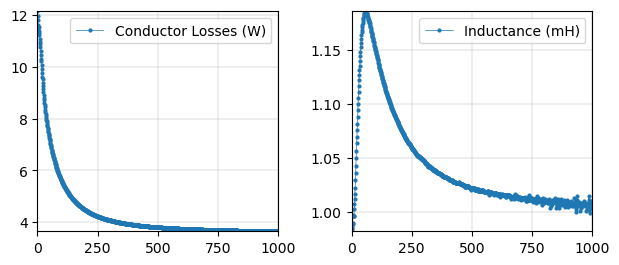

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

Starting optimization with mmg...


c:\Users\SESA811965\Code\temp\inductance-compumag\notebooks\shapeOptInductor.py:633: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(0, len(curve) - 1)
c:\Users\SESA811965\Code\temp\inductance-compumag\notebooks\shapeOptInductor.py:636: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(min_y, max_y)


It = 0; Losses = 12.135863860828366 W; Inductance = 0.9824631133355824 mH
It = 1; Losses = 11.95597596573274 W; Inductance = 0.9844579343883632 mH
It = 2; Losses = 11.784496604953627 W; Inductance = 0.9858550563606847 mH
It = 3; Losses = 11.617364918669205 W; Inductance = 0.9873489966489998 mH
It = 4; Losses = 11.454425950162813 W; Inductance = 0.9889171170824081 mH
It = 5; Losses = 11.295545381359382 W; Inductance = 0.9905392201225761 mH
It = 6; Losses = 11.547927772557992 W; Inductance = 0.9972428440205674 mH
It = 7; Losses = 11.38109545208828 W; Inductance = 0.996751157928476 mH
It = 8; Losses = 11.216722687851677 W; Inductance = 0.9965418202508874 mH
It = 9; Losses = 11.054617591006393 W; Inductance = 0.9966021711811759 mH
It = 10; Losses = 10.894611249934625 W; Inductance = 0.9969211887919885 mH
It = 11; Losses = 10.943129580481976 W; Inductance = 1.0032382184823643 mH
It = 12; Losses = 10.779754342813092 W; Inductance = 1.007582135311865 mH
It = 13; Losses = 10.61732038223758 W; 

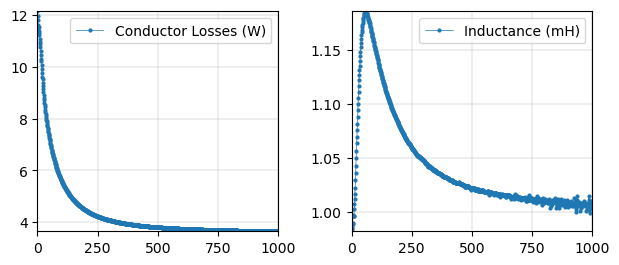

In [30]:
from nullspace_optimizer import nlspace_solve

mesh = gen_mesh(air_gap=4.11e-3, maxh=1e-3)
listener = DisplayListener(mesh)

problem = ShapeOpt(
    mesh, 
    SolveDeformationEquation, 
    listener=listener, 
    use_mmg=True, 
    mmg_hausd=1e-6, 
    mmg_hmax=1e-3, 
    mmg_hmin=1e-4
)

params = {
    'maxit': 1000,
    'maxtrials' : 1,
    'tol' : 1e-11,
    'alphaJ' : 5e-4,
    'debug': 1,
    'dt': 1e-1,
    'debug' : -1,
}

print("Starting optimization with mmg...")
import time
start = time.time()
opt_results = nlspace_solve(problem, params)
end = time.time()
duration = end - start
print(f"Duration : {duration//60} min {duration%60:.0f} s")

new_mesh = opt_results['x'][-1]
iter_i = opt_results['it'][-1]
fes = ngs.H1(new_mesh, order=1, dirichlet="d|e|f|g", complex=True)
state, _ = solveStateComplex(fes)

print(f"\nThe optimization converged in {iter_i} iterations")
print(f"The inductance is {1e3 * np.absolute(Inductance(state, new_mesh))} mH")
print(f"The losses amounts to {Losses(state, new_mesh)} W")